# Problem Set 3: Regression and Classification

**Release Date:** 15 September 2025 1800H

**Due Date:** 11 October 2025 2359H

## Overview

We have learned how to solve a regression problem using linear regression in class.
Specifically, we will use the normal equation and gradient descent methods, and apply it to linear regression and polynomial regression models to predict housing prices in Singapore.

We have also learned about logistic regression, and how it can be useful as a classification algorithm. We will get some hands-on practice by implementing logistic regression on a Credit Card Fraud Detection dataset. 

**Required Files**:
* ps3.ipynb
* housing_data.csv
* credit_card.csv

**Plagiarism Policy**: Please refer to our [Course Policies](https://canvas.nus.edu.sg/courses/77861/pages/course-policies).

**IMPORTANT**: While it is possible to write and run Python code directly in Jupyter notebook, we recommend that you do this Problem set with an IDE using the .py file provided. An IDE will make debugging significantly easier.

**Post-Problem Set Survey**:
Your feedback is important to us! After completing Problem Set 3, please take a moment to share your thoughts by filling out this [survey](https://coursemology.org/courses/3095/surveys/2720).

## Orientation to files

**ps3.ipynb**:
The template for all your tasks is provided in this file. Some test cases have
been provided for you to check the output of your algorithm against the expected result. The tests are **not** comprehensive, and you are
encouraged to write your own tests to check for correctness.

**housing.csv**:
The CSV file contains a dataset with housing data.
There are 90 data points. Each data point consists of 3 features:
* **floor_area_sqm** - size of the house in square meters
* **bedrooms** - number of bedrooms
* **schools** - number of primary schools within a 1km radius

Our target value is the **asking_price**, which is the price of the housing unit.

### IMPORTANT

Similar to PS0, your implementation in the following tasks **should not
involve any iteration, including `map` and `filter`, or recursion**. Instead, please work
with the operations available in NumPy. Solutions that violate this will be penalised.

- You are allowed to use any mathematical functions, but this does not mean that you are allowed to use any NumPy function (there are NumPy functions that aren’t mathematical functions). For example, `np.vectorize` is not allowed since it is iterative. If you are in doubt about which functions are allowed, you should ask in the forum.


There is, however, an exception for **Tasks 2.6, 2.8 and 3.5**. In the pseudo-code for the
algorithm required, there is an explicit for loop for Tasks 2.6 and 3.5, and a while loop for Task 2.8. Hence, **only for these tasks**, you
may use a **single for/while loop** to iterate for the number of epochs required.

In [40]:
# Inital imports and setup

import os
import numpy as np

###################
# Helper function #
###################
def load_data(filepath):
    '''
    Load in the given csv filepath as a numpy array

    Parameters
    ----------
    filepath (string) : path to csv file

    Returns
    -------
        X, y (np.ndarray, np.ndarray) : (n, num_features), (n,) numpy matrices
    '''
    *X, y = np.genfromtxt(
        filepath,
        delimiter=',',
        skip_header=True,
        unpack=True,
    ) # default dtype: float
    X = np.array(X, dtype=float).T # cast features to int type
    return X, y.reshape((-1, 1))

data_filepath = 'housing_data.csv'
X, y = load_data(data_filepath)

## Part 1: Defining cost functions

We need to define cost functions before creating a linear regression model to calculate
the error between our prediction and the true values. We will define two cost functions:
Mean Squared Error (MSE) and Mean Absolute Error (MAE).

### Task 1.1: Mean Squared Error (MSE)

Write the function `mean_squared_error(y_true, y_pred)` that returns a number representing the mean squared error of the predictions.

The formula for Mean Squared Error is as follows:
$$ MSE(\boldsymbol{y}, \boldsymbol{\hat{y}}) = \frac{1}{2n} \sum_{i=1}^{n}\left(\hat{y}^{(i)} - y^{(i)}\right)^2 $$

where $\boldsymbol{y}$ is the vector with actual values, $\boldsymbol{\hat{y}}$ is the prediction vector, and $n$ is the number of samples in the
training data.

**Remark**: The formula here follows the lecture slides for consistency. In definitions and implementations elsewhere, the denominator is usually just $n$ instead of $2n$.

**Hint**: Consider using `np.square` or `np.power`.


In [41]:
def mean_squared_error(y_true, y_pred):
    '''
    Calculate mean squared error between y_pred and y_true.

    Parameters
    ----------
    y_true (np.ndarray) : (n, 1) numpy matrix consists of true values
    y_pred (np.ndarray) : (n, 1) numpy matrix consists of predictions
    
    Returns
    -------
        The mean squared error value.
    '''
    
    """ YOUR CODE HERE """
    n = len(y_true)
    error = np.square(y_pred - y_true)
    mse = (1 / (n*2)) * np.sum(error)
    return mse
    """ YOUR CODE END HERE """

In [42]:
# Test cases
y_true, y_pred = np.array([[3], [5]]), np.array([[12], [15]])

assert mean_squared_error(y_true, y_pred) in [45.25, 90.5]

### Task 1.2: Mean Absolute Error (MAE)

Write the function `mean_absolute_error(y_true, y_pred)` that returns a number representing the mean absolute error of the predictions.

The formula for Mean Absolute Error is as follows:
$$ MAE(\boldsymbol{y}, \boldsymbol{\hat{y}}) = \frac{1}{n} \sum_{i=1}^{n}\left|\hat{y}^{(i)} - y^{(i)}\right| $$

where $\boldsymbol{y}$ is the vector with actual values, $\boldsymbol{\hat{y}}$ is the prediction vector, and $n$ is the number of samples in the
training data.

**Hint**: Consider using `np.abs`.


In [43]:
def mean_absolute_error(y_true, y_pred):
    '''
    Calculate mean absolute error between y_pred and y_true.

    Parameters
    ----------
    y_true (np.ndarray) : (n, 1) numpy matrix consists of true values
    y_pred (np.ndarray) : (n, 1) numpy matrix consists of predictions
    
    Returns
    -------
        The mean absolute error value.
    '''
  
    """ YOUR CODE HERE """
    n = len(y_true)
    error = np.abs(y_pred - y_true)
    mae = (1/n) * np.sum(error)
    return mae
    """ YOUR CODE END HERE """

In [44]:
# Test cases
y_true, y_pred = np.array([[3], [5]]), np.array([[12], [15]])

assert mean_absolute_error(y_true, y_pred) == 9.5

## Part 2: Linear Regression

Now we’re ready to create our own linear regression model. We will try to find a linear function, which can be written as follows:

$$ y = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_d x_d $$

where $y$ is the target value, $x_1, x_2, \dots, x_d$ are feature values, and $w_0, w_1, \dots, w_d$ are parameters, where $d$ is the number of features. $w_0$ is meant to represent the bias term, while $w_1, \dots, w_d$ are the feature weights.

**Bias term**

The bias term ($w_0$) is useful in capturing an inherent offset of the target values from the origin, i.e. they have some non-zero "default" or "starting" value. The bias term accounts for this default value in our model. Without a bias term (or bias = 0), our regression lines will pass through the origin, which might not be appropriate for the data in question.

Consider the scatter plot below. The blue line is the best fitting line without a bias term, while the red line includes a non-zero bias. Since the blue line starts at the origin, it is unable to capture the offset of the points. In contrast, the red line starts higher (at around 5), and hence is better able to approximate the data.

&nbsp;
<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center">
<img src="./images/bias_scatter.png" alt="bias vs no bias" width="40%">
<figcaption style="text-align:center">Figure 1: Example of models with bias vs without bias.</figcaption>
</figure>

Usually, we have to explicitly add a bias term into our data when building our models. In the following tasks, you'll explore how to do so and how this choice can affect the accuracy of your models.

### Task 2.1: Adding a bias column

In the lecture, we learned that adding a bias allows our linear model to be more
flexible. Write the function `add_bias_column(X)` that takes a NumPy matrix `X` and returns
a new matrix with an additional column. The additional column should have all of its
elements set to 1 and is located at the first column of the matrix.

<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center">
<img src="./images/add_bias.jpeg" alt="adding bias" width="50%">
<figcaption style="text-align:center">Figure 2: Example of a matrix before and after adding a bias column.</figcaption>
</figure>

**Note**: Your function should work for all kinds of matrix shapes.

**Hint**: Consider using `np.hstack` to add the bias column.


In [45]:
def add_bias_column(X):
    '''
    Create a bias column and combine it with X.

    Parameters
    ----------
    X : (n, d) numpy matrix representing a feature matrix
    
    Returns
    -------
        new_X (np.ndarray):
            A (n, d + 1) numpy matrix with the first column consisting of all 1s
    '''
  
    """ YOUR CODE HERE """
    arr = np.ones((np.shape(X)[0], 1))
    bias = np.hstack((arr, X))
    return bias
    """ YOUR CODE END HERE """

In [46]:
# Test cases
without_bias = np.array([[1, 2], [3, 4]])
expected = np.array([[1, 1, 2], [1, 3, 4]])

assert np.array_equal(add_bias_column(without_bias), expected)

### Normal Equation

We will first use the normal equation to obtain $w_0, w_1, \dots, w_d$. The solution to the normal equation is as
follows:

$$ \begin{pmatrix} w_0 \\ w_1 \\ \vdots \\ w_d \end{pmatrix} = (X^TX)^{-1}X^T \boldsymbol{y} $$

where $X$ is the (augmented for bias) feature matrix and $\boldsymbol{y}$ is the vector of target values.

### Task 2.2: Find optimal bias and weights using normal equation

Write the function `get_bias_and_weight(X, y, include_bias)` that returns $w_0$ (bias) and
$w_1, w_2, \dots, w_d$ (weights) that will lead to best fitting line, using the **normal equation** method. 

The `include_bias` argument is used to specify if the model includes a bias term, i.e. has a non-zero bias term. Hence, the function should return $w_0 = 0$ if it is set to `false`. The function should return $w_1, \dots, w_d$ as a NumPy matrix with shape $(d, 1)$, where $d$ is the number of features (excluding the bias column).

**Note**: Make use of the `add_bias_column` function for this task. (The function has been predefined for you in Coursemology. Do not redefine the function.)

**Hint**: Consider using `numpy.linalg.inv` for the matrix inverse.


In [47]:
def get_bias_and_weight(X, y, include_bias = True):
    '''
    Calculate bias and weights that give the best fitting line.

    Parameters
    ----------
    X (np.ndarray) : (n, d) numpy matrix representing feature matrix
    y (np.ndarray) : (n, 1) numpy matrix representing target values
    include_bias (boolean) : Specify whether the model should include a bias term
    
    Returns
    -------
        bias (float):
            If include_bias = True, return the bias constant. Else,
            return 0
        weights (np.ndarray):
            A (d, 1) numpy matrix representing the weight(s).
    '''
  
    """ YOUR CODE HERE """
    if include_bias:
        X = add_bias_column(X)  # add bias
        # X.T is just the transpose of X, @ is just for matrix mulitplication
        weights = np.linalg.inv(X.T @ X) @ X.T @ y
        bias = weights[0, 0]
        weights = weights[1:]
    else:
        weights = np.linalg.inv(X.T @ X) @ X.T @ y
        bias = 0
    return bias, weights
    """ YOUR CODE END HERE """

In [48]:
# Test cases
public_X, public_y = np.array([[1, 3], [2, 3], [3, 4]]), np.arange(4, 7).reshape((-1, 1))

test_1 = (round(get_bias_and_weight(public_X, public_y)[0], 5) == 3)
test_2 = np.array_equal(np.round(get_bias_and_weight(public_X, public_y)[1], 1), np.array([[1.0], [0.0]]))
test_3 = np.array_equal(np.round(get_bias_and_weight(public_X, public_y, False)[1], 2), np.round(np.array([[0.49], [1.20]]), 2))

assert test_1 and test_2 and test_3

### Task 2.3: Get the prediction line

Write the function `get_prediction_linear_regression(X, y, include_bias)` that returns `y_pred`,
a vector of predicted values for the training data.

**Note**: Make use of the `get_bias_and_weight` function for this task. (The function has been predefined for you in Coursemology. Do not redefine the function.)


In [49]:
def get_prediction_linear_regression(X, y, include_bias = True):
    '''
    Calculate the best fitting line.

    Parameters
    ----------
    X (np.ndarray) : (n, d) numpy matrix representing feature matrix
    y (np.ndarray) : (n, 1) numpy matrix representing target values
    include_bias (boolean) : Specify whether the model should include a bias term

    Returns
    -------
        y_pred (np.ndarray):
            A (n, 1) numpy matrix representing prediction values.
    '''
  
    """ YOUR CODE HERE """
    bias, weight = get_bias_and_weight(X, y, include_bias)
    y_pred = X @ weight
    if include_bias:
        y_pred += bias
    return y_pred
    """ YOUR CODE END HERE """

In [50]:
# Test cases
test_X, test_y = np.array([[1, 3], [2, 3], [3, 4]]), np.arange(4, 7).reshape((-1, 1))

assert round(mean_squared_error(test_y, get_prediction_linear_regression(test_X, test_y)), 5) == 0

To check your work, create a linear regression model with **floor_area_sqm** as the only
feature and **asking_price** as the target value. Plot your prediction line using the code
snippet below. It should look similar to Figure 3.

&nbsp;
<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center">
<img src="./images/linear_reg.png" alt="regression plot" width="50%">
<figcaption style="text-align:center">Figure 3: Example of linear regression using <b>floor_area_sqm</b> as feature.</figcaption>
</figure>

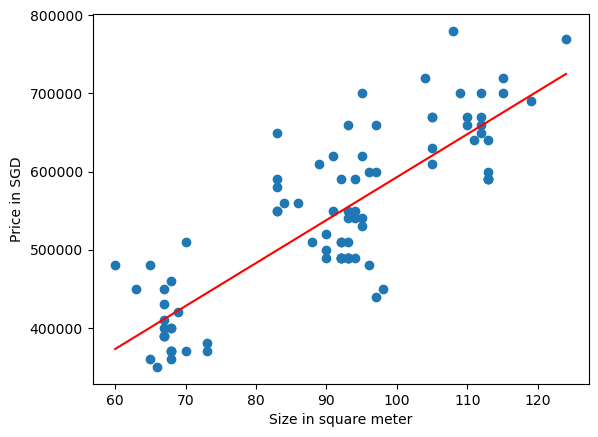

In [51]:
import matplotlib.pyplot as plt

area = X[:, 0].reshape((-1, 1))
predicted = get_prediction_linear_regression(area, y)
plt.scatter(area, y)
plt.plot(area, predicted, color = 'r')
plt.xlabel("Size in square meter")
plt.ylabel("Price in SGD")
plt.show()

### Polynomial Features

In real-world data, a straight line might not fit the data perfectly. Consider the relation between **schools** and **asking_price**.

&nbsp;
<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center">
<img src="./images/school_price_rel.png" alt="school price relation" width="50%">
<figcaption style="text-align:center">Figure 4: Schools - Price Relationship.</figcaption>
</figure>

Houses with 0 schools nearby tend to be cheaper than houses with 1 school nearby. However, as the number of schools increases, the prices decrease. If we try a linear regression on the data, we obtain a straight line. Notice how we lose the detail that houses with 0 schools are actually cheaper than houses with 1 school nearby. A polynomial function can better capture this relationship.

&nbsp;
<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center">
<div>
<img src="./images/school_price_rel_linearfit.png" alt="school price relation linear fit" width="45%">
<img src="./images/school_price_rel_cubicfit.png" alt="school price relation cubic fit" width="45%">
</div>
<figcaption style="text-align:center">Figure 5: Schools - Price Relationship With Linear and Cubic fit.</figcaption>
</figure>

A polynomial function is written as follows:

$$ y = w_0 + w_1 x + w_2 x^2 + ... + w_d x^d $$

where $y$ is the target value, $x$ is a (*single*) feature value, and $d$ is the degree of the polynomial. $w_0$ is the bias term and $w_1, \dots, w_d$ are the feature weights. 

Notice how if we set $x_1 = x, x_2 = x^2, \dots, x_d = x^d$, then the polynomial function is simply linear regression with $d$ features:

$$ y = w_0 + w_1 x_1 + w_2 x_2 + ... + w_d x_d $$

### Task 2.4 : Create Polynomial Matrix

Write the function `create_polynomial_matrix(X, power)` that takes a $(n, 1)$-matrix and an
integer, and returns a polynomial matrix with shape $(n, power)$.

$$
\left[\begin{array}{cc} 
1\\
2\\
3
\end{array}\right]
\xrightarrow[]{\text{create\_polynomial\_matrix(3)}}
\left[\begin{array}{cc} 
1 & 1^2 & 1^3\\ 
2 & 2^2 & 2^3\\
3 & 3^2 & 3^3
\end{array}\right]
\rightarrow
\left[\begin{array}{cc} 
1 & 1 & 1\\ 
2 & 4 & 8\\
3 & 9 & 27
\end{array}\right]
$$

**Hint**: Consider using `np.tile`/`np.repeat` together with `np.cumprod`/`np.power`.


In [53]:
def create_polynomial_matrix(X, power = 2):
    '''
    Create a polynomial matrix.
    
    Parameters
    ----------
    X: (n, 1) numpy matrix

    Returns
    -------
        A (n, power) numpy matrix where the i-th column denotes
            X raised to the power of i.
    '''
    """ YOUR CODE HERE """
    poly = np.cumprod(np.tile(X, power), axis=1)
    return poly
    """ YOUR CODE END HERE """

In [54]:
# Test cases
vector = np.array([[1], [2], [3]])
poly_matrix = np.array([[1, 1, 1], [2, 4, 8], [3, 9, 27]])

assert np.array_equal(create_polynomial_matrix(vector, 3), poly_matrix)

### Task 2.5: Get the prediction line

Write the function `get_prediction_poly_regression(X, y, power, include_bias)` that returns
`y_pred`, a vector of predicted values for the training data.

**Note**: Make use of the `create_polynomial_matrix` and `get_prediction_linear_regression` function for this task. (The function has been predefined for you in Coursemology. Do not redefine the function.)


In [56]:
def get_prediction_poly_regression(X, y, power = 2, include_bias = True):
    '''
    Calculate the best polynomial line.

    Parameters
    ----------
    X (np.ndarray) : (n, 1) numpy matrix representing feature matrix
    y (np.ndarray) : (n, 1) numpy matrix representing target values
    power (int) : Specify the degree of the polynomial
    include_bias (boolean) : Specify whether the model should include a bias term

    Returns
    -------
        A (n, 1) numpy matrix representing prediction values.
    '''
    """ YOUR CODE HERE """
    poly = create_polynomial_matrix(X, power)
    y_pred = get_prediction_linear_regression(poly, y, include_bias)
    return y_pred
    """ YOUR CODE END HERE """

In [58]:
# Test cases
test_X, test_y = np.arange(3).reshape((-1, 1)), np.arange(4, 7).reshape((-1, 1))
pred_y = get_prediction_poly_regression(test_X, test_y, 2)

assert round(mean_squared_error(test_y, pred_y), 5) == 0

To check your work, create a polynomial regression model, using `power = 3` and `include_bias = True`, with **schools** as the only feature and **asking_price** as the target value. Plot your prediction line using the code snippet below. It should look similar to Figure 6.

&nbsp;
<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center">
<img src="./images/poly_reg.png" alt="polynomial regression" width="50%">
    <figcaption style="text-align:center">Figure 6: Example of polynomial regression using <b>schools</b> as feature.</figcaption>
</figure>

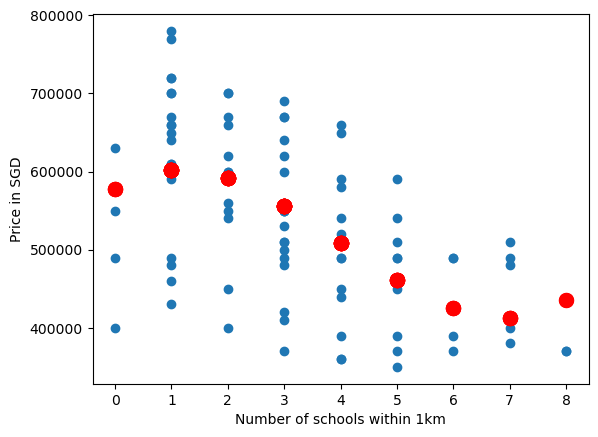

In [60]:
import matplotlib.pyplot as plt

schools = X[:, 2].reshape((-1, 1))
predicted = get_prediction_poly_regression(schools, y, 3)
plt.scatter(schools, y)
plt.scatter(schools, predicted, color = 'r', s = 100)
plt.xlabel("Number of schools within 1km")
plt.ylabel("Price in SGD")
plt.show()

### Gradient Descent

We will now learn to use gradient descent to approximate $\boldsymbol{w} = w_0, w_1, \dots, w_d$.

*Gradient descent*<sup>&#x2020;</sup> is an algorithm that minimizes the cost function by iteratively trying to
find the best parameters. In linear regression, we will try to minimize the Mean Squared
Error. The outline of the algorithm is as follows:
    
* Start with some $\boldsymbol{w} = (w_0, \dots, w_d)$
* Keep changing $w_0,\dots, w_d$ to minimize $J(\boldsymbol{w})$, where $J$ is our cost function

In this problem set, we will initially set $w_0, w_1, \dots, w_d$ to all be 0s. Then, we will set a
learning rate $\gamma$ that will affect the rate of change of $w_0, \dots, w_d$. Lastly, we will set
$T$ to specify the number of epochs of gradient descent we want to run.

The pseudo-code of Gradient Descent for linear regression is defined in Algorithm 1.

**Note**: In the following gradient descent-related tasks, calculate the value of the loss function *after* updating the bias and weights.

<sup>&#x2020;</sup> *The Gradient Descent algorithm is not limited to the linear regression model – it is a general optimisation technique and is also used in many other machine learning models such as Neural Networks.*

<div style="display: flex; justify-content: center; align-items: center;">
    <img src="./images/mse_plot.png" alt="gradient descent" style="width: 45%; margin-right: 10px;">
    <img src="./images/grad_desc_algorithm.png" alt="gradient descent" style="width: 45%;">
</div>
<figcaption style="text-align:center; margin-top: 10px;">Figure 7: Gradient descent tries to find parameters that lead to the lowest MSE.</figcaption>

For MSE, The partial derivative $\frac{\partial J_{MSE}(\boldsymbol w)}{\partial w_j}$ with $n$ training samples can be derived as: 
$$
\frac{\partial J_{MSE}(\boldsymbol{w})}{\partial w_j} = \frac 1n\sum^n_{i=1}(h_w(x^{(i)})-y^{(i)})\cdot x_j^{(i)} 
$$
where $h_w$ is our hypothesis.

### Task 2.6: Gradient Descent on multiple features

Write the function `gradient_descent_multi_variable(X, y, lr, number_of_epochs)` that returns:

* $w_0$ - a number representing the bias constant
* $w_1, w_2, \dots, w_d$ - $(d, 1)$ NumPy matrix, where each element denotes the weights of a certain feature
* $loss$ - a list that contains the MSE scores calculated during the gradient descent process.

**Note**: Make use of the `mean_squared_error` function for this task. (The function has been predefined for you in Coursemology. Do not redefine the function.)


In [62]:
def gradient_descent_multi_variable(X, y, lr = 1e-5, number_of_epochs = 250):
    '''
    Bias and weight that gives the best fitting line.

    Parameters
    ----------
    X (np.ndarray) : (n, d) numpy matrix representing feature matrix
    y (np.ndarray) : (n, 1) numpy matrix representing target values
    lr (float) : Learning rate
    number_of_epochs (int) : Number of gradient descent epochs
    
    Returns
    -------
        bias (float):
            The bias constant
        weights (np.ndarray):
            A (d, 1) numpy matrix that specifies the weights.
        loss (list):
            A list where the i-th element denotes the MSE score at i-th epoch.
    '''
    # Do not change
    bias = 0
    weights = np.full((X.shape[1], 1), 0).astype(float)
    loss = []

    n = X.shape[0]  # number of datapoints
    pred = X @ weights + bias
    for _ in range(number_of_epochs):
        """ YOUR CODE HERE """
        bias -= lr * (1/n) * (np.sum(pred-y))
        weights -= lr * (1/n) * (X.T @ (pred-y))
        mse = mean_squared_error(y, pred)
        loss.append(mse)
        pred = bias + (X @ weights)
        """ YOUR CODE END HERE """
    
    return bias, weights, loss

In [64]:
# Test cases
_, _, loss = gradient_descent_multi_variable(X, y, lr = 1e-5, number_of_epochs = 250)
loss_initial = loss[0]
loss_final = loss[-1]

assert loss_initial > loss_final

### Task 2.7 Feature Scaling

As we create a higher degree polynomial matrix, each column will have a larger scale
than the previous one, which can lead to poor performance for gradient descent. This also applies to datasets with multiple features where the features are already of different scales. Here
is where feature scaling plays an important role. 

Write the function `feature_scaling(X)`
that takes a NumPy matrix `X` and returns a matrix with standardized columns.

**Note**: The normalization occurs on the column level ($i$-th column is normalized by the
mean and standard deviation of the $i$-th column). That is,

$$
\text{If} \quad \boldsymbol{v} = \begin{pmatrix} v_1 \\ v_2 \\ \vdots \\ v_N \end{pmatrix} \\
\\
\boldsymbol{v}_{norm} = \frac{\boldsymbol{v} - \boldsymbol{\hat{v}}}{\sigma_{v}}
$$

where $\boldsymbol{v}$ is a vector of $n$ elements, $\boldsymbol{\hat{v}}$ is its mean, and $\sigma_{v}$ is its standard deviation.

$$
\left[\begin{array}{cc} 
1 & 133\\
4 & 700\\
5 & 133\\
8 & 700
\end{array}\right]
\xrightarrow[]{\text{feature\_scaling}}
\left[\begin{array}{cc} 
-1.4 & -1\\
-0.2 & 1\\
0.2 & -1\\
1.4 & 1
\end{array}\right]
$$ 

Focusing on the first feature:

$$
\boldsymbol{v} = \left(\begin{array}{cc}
1\\
4\\
5\\
8
\end{array}\right), \boldsymbol{\hat{v}} = 4.5, \sigma_{v} = 2.5$$

$$\boldsymbol{v}_{norm} = \frac{\boldsymbol{v} - 4.5}{2.5} = \left(\begin{array}{cc}
-1.4\\
-0.2\\
0.2\\
1.4
\end{array}\right)
$$

**Hint**: Consider using `np.mean()` and `np.std()`.


In [66]:
def feature_scaling(X):
    '''
    Standardize each feature column.

    Parameters
    ----------
    X (np.ndarray) : (n, d) numpy matrix representing feature matrix

    Returns
    -------
        A (n, d) numpy matrix where each column has been standardized.
    '''
    """ YOUR CODE HERE """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    norm = (X-mean)/std
    return norm
    """ YOUR CODE END HERE """

In [67]:
# Test cases
public_X = np.array([[1, 133], [4, 700], [5, 133], [8, 700]])
expected = np.array([[-1.4, -1], [-0.2, 1], [0.2, -1], [1.4, 1]])

assert np.array_equal(feature_scaling(public_X), expected)

### Task 2.8: Finding the number of epochs for gradient descent to converge

Fill in the function `find_number_of_epochs(X, y, lr, delta_loss)` that that returns:

* $w_0$ - a number representing the bias constant
* $w_1, w_2, \dots, w_d$ - $(d, 1)$ NumPy matrix, where each element denotes the weights of a certain feature
* $num\_of\_epochs$ - a number representing the number of epochs performed to reach convergence

A single epoch is defined as performing the gradient descent *once* and calculating the loss. The loss calculation and gradient descent should be performed using MSE.

The definition of convergence is as follows:

$$ |J_{t-1} - J_{t}| < delta\_loss $$

where $J_{t-1}$ is loss at timestep $t-1$ (previous timestep), $J_{t}$ is loss at timestep $t$ (current timestep), and $delta\_loss$ is the termination criterion.

**Note**: Make use of the `mean_squared_error` function for this task. (The function has been predefined for you in Coursemology. Do not redefine the function.)


In [70]:
def find_number_of_epochs(X, y, lr, delta_loss):
    '''
    Do gradient descent until convergence and return number of epochs
    required.

    Parameters
    ----------
    X (np.ndarray) : (n, d) numpy matrix representing feature matrix
    y (np.ndarray) : (n, 1) numpy matrix representing target values
    lr (float) : Learning rate
    delta_loss (float) : Termination criterion
    
    Returns
    -------
        bias (float):
            The bias constant
        weights (np.ndarray):
            A (d, 1) numpy matrix that specifies the weights.
        num_of_epochs (int):
            Number of epochs to reach convergence.
        current_loss (float):
            The loss value obtained after convergence.
    '''
    # Do not change
    bias = 0
    weights = np.full((X.shape[1], 1), 0).astype(float)
    num_of_epochs = 0
    previous_loss = 1e14
    current_loss = -1e14

    n = X.shape[0]
    pred = X @ weights + bias
    current_loss = mean_squared_error(y, pred)
    while abs(previous_loss - current_loss) >= delta_loss:
        """ YOUR CODE HERE """
        bias -= lr * (1/n) * (np.sum(pred-y))
        weights -= lr * (1/n) * (X.T @ (pred-y))
        pred = bias + (X @ weights)
        previous_loss = current_loss
        current_loss = mean_squared_error(y, pred)
        num_of_epochs += 1
        """ YOUR CODE END HERE """
        """ YOUR CODE END HERE """
    
    return bias, weights, num_of_epochs, current_loss

In [71]:
# Test cases
poly_X = create_polynomial_matrix(X[:, 2].reshape((-1, 1)), 3)
_, _, num_of_epochs, _ = find_number_of_epochs(poly_X, y, 1e-5, 1e7)

assert num_of_epochs > 0

### Task 2.9: Which algorithm should we use for Linear Regression?

Compare the pros and cons of using normal equation and gradient descent for linear regression. Specifically:

- Compare the speed of the two algorithms on data with many features. 
- Compare the quality of the solutions obtained by the two algorithms. (i.e. how close to the optimal solution are the solutions obtained by the algorithms)
- Compare whether feature scaling is necessary for each algorithm to perform well.

Finally, select the algorithm you think is more suitable for this dataset and explain why you chose it.


Speed - gradient descent is more efficient on data with many features, compared to normal equations (due to the calculation of the normal equation)

Closeness to optimal solution - Gradient descent iteratively converges on the optimal solution but might get stuck at local minima for non-convex problems. Whereas, normal equations will be able to find the exact solution quickly

Feature scaling - gradient descent requires scaling but normal equations do not

Since this dataset is small, usingn normal equation is better.

### Task 2.10: Analyze the effects of feature scaling on Gradient Descent

In this task, we will examine the influence of feature scaling on the efficiency of gradient descent algorithms. Specifically, we utilize a degree 3 polynomial feature matrix derived from a dataset of schools.

<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center">
<img src="./images/loss_vs_epochs.png" alt="loss against epochs with and without normalization" width="90%">
<figcaption style="text-align:center">Figure 8: Loss against epoch count, for gradient descent without and with normalization</figcaption>
</figure>

Focus on two key aspects:

1. Convergence analysis
    - Observe the number of epochs required to achieve convergence for both the non-normalized (original) and normalized feature matrices.  
    This comparison should be conducted across various learning rates.
2. Loss visualization
    - Analyze the loss values corresponding to both the non-normalized and normalized matrices as a function of epoch count, again considering different learning rates.


**Draw 2 observations or conclusions** from the above figures.


The algorithm converges faster with normalised features for all learning rates. Without normalisation, convergence takes a lot more time.

The algorithm also achieves lower final loss values with normalisation. Without normalisation, loss values are much higher even with the same number of epochs.

## Part 3: Logistic Regression

### Introduction

Fraudulent credit card transaction is a common phenomenon in many parts of the world and can lead to potentially large amounts of losses for both companies and customers. Therefore, we hope to help credit card companies recognize those fraudulent transactions so that customers are not charged for items that they did not purchase.

We are given a dataset that contains transactions made by credit cards holders in `credit_card.csv`. If we think about what type of data might be included in the input variables under the given context, we might realize that those input variables are likely to include word descriptions, such as shop name or locations. In this problem set, we don't need to worry about language processing as the data are pre-processed to contain only numeric values.

### Getting Started

Take a look at the columns in the dataset `credit_card.csv`. We have V1-V20, 'Amount', and 'Time' as input features, and 'Class' as output which takes the value 1 if it's fraud and 0 otherwise. This dataset presents 492 frauds out of 284,807 transactions. That means, there are 284,808 rows (including the header) in the csv file.

We will use this dataset to implement logistic regression using stochastic gradient descent for binary classification.

In [121]:
# Initial imports and setup

import numpy as np
import os
import pandas as pd

from sklearn import svm
from sklearn import model_selection

# Read credit card data into a Pandas dataframe for large tests

dirname = os.getcwd()
credit_card_data_filepath = os.path.join(dirname, 'credit_card.csv')

credit_df = pd.read_csv(credit_card_data_filepath)
X_task5 = credit_df.values[:, :-1]
y_task5 = credit_df.values[:, -1:]

### Basics of Pandas

[Pandas](https://pandas.pydata.org/) is an open source data analysis and manipulation tool in Python. In this problem set, we read the CSV into a [Pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to provide some nifty methods that makes it easier for us to handle large amounts of data. You can think of a dataframe as a large table that stores our dataset in a neat and optimized manner, making it fast for retrieval and manipulation and data. Using Pandas, we can quickly gain an overview of the type and values of the data stored, distributions of values within the dataset, and even ways to perform sampling.

In the new few sections, we will explore some basic functions of Pandas to help us get started. You do not need to submit any codes for this section, and can simply run the cells to follow along.

### Exploring the dataset

Using the [`head`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) method on the dataframe, we can get an overview of the data. By default, the method returns the first 5 entries in the dataframe.

Next, we can inspect the [value counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) of the 'Class' property in the dataframe to know the number of fraudulent and non-fraudulent transactions.

In [77]:
print(credit_df.head())

# Inspect the number of fraudulent and non-fraudulent transactions.
print(credit_df['Class'].value_counts())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V13       V14       V15       V16       V17  \
0  0.098698  0.363787  ... -0.991390 -0.311169  1.468177 -0.470401  0.207971   
1  0.085102 -0.255425  ...  0.489095 -0.143772  0.635558  0.463917 -0.114805   
2  0.247676 -1.514654  ...  0.717293 -0.165946  2.345865 -2.890083  1.109969   
3  0.377436 -1.387024  ...  0.507757 -0.287924 -0.631418 -1.059647 -0.684093   
4 -0.270533  0.817739  ...  1.345852 -1.119670  0.175121 -0.451449 -0.237033   

        V18       V19       V20 

### Indexing and selecting data

Similar to NumPy, we can also index and select data on Pandas dataframes.

For example, we can [select columns in the dataframe by their labels](https://pandas.pydata.org/docs/user_guide/indexing.html#basics). We use `'Class'` to index the 'Class' column in the credit dataframe, or use integer indexing.

In [79]:
# Select the 'Class' column in the credit dataframe
print(credit_df['Class'])

# Obtain the first 2 rows
print(credit_df[0:2])

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   

         V8        V9  ...       V13       V14       V15       V16       V17  \
0  0.098698  0.363787  ... -0.991390 -0.311169  1.468177 -0.470401  0.207971   
1  0.085102 -0.255425  ...  0.489095 -0.143772  0.635558  0.463917 -0.114805   

        V18       V19       V20  Amount  Class  
0  0.025791  0.403993  0.251412  149.62      0  
1 -0.183361 -0.145783 -0.069083    2.69      0  

[2 rows x 23 columns]


We can also [select columns in the dataframe that fulfils some condition](https://pandas.pydata.org/docs/user_guide/indexing.html#boolean-indexing). In the example below, `credit_df['Class'] == 0` returns a [Pandas Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) of length 284807, which is the size of our dataset. It contains the value `True` if and only if the `Class` value for the particular entry is of value 0, and `False` otherwise. We can use this Boolean series to index the credit dataframe to return the rows where the `Class` field is 0. Does this remind you of how NumPy arrays operate?

In [82]:
print(credit_df['Class'] == 0)

# Obtain the credit dataframe where the 'Class' field is 0
print(credit_df[credit_df['Class'] == 0])

0         True
1         True
2         True
3         True
4         True
          ... 
284802    True
284803    True
284804    True
284805    True
284806    True
Name: Class, Length: 284807, dtype: bool
            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
28

You can also [concatenate](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) Pandas series or dataframes together! In this example, we explored how we can concat the first 2 rows and last 2 rows of the dataframe. Similar to NumPy, you would also need to specify the axis for concatenation.

In [84]:
pd.concat([credit_df[:2], credit_df[-2:]], axis=0)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V13,V14,V15,V16,V17,V18,V19,V20,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,2.69,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,217.00,0


### Task 3.1: Problem with imbalanced data

Investigate the dataset by comparing the number of fradulent and non-fradulent transactions. Describe in one or two sentences what problem we might encounter if we directly use the given dataset without processing it. How can we address this issue? 

Hint: consider the `Class` column, and think about how a high accuracy prediction can be achieved in a wrong way


There are an overwhelming majority of non-fraudulent transactions (284315) compared to fraudulent transactions (492).
As a result, our model could simply output everything as non-fraudulent.

### Splitting data

Before we can start training our models, we need to **randomly** partition our dataset into training data and testing data. 

Remember that we are trying to make a model that can predict fraudulence of data points that the model has never seen. It would be unwise to measure the accuracy of the model using the same data it trained on, as that does not give you an idea of how well the model will work on unseen data. Hence, we will have to train the model on a training set and evaluate its effectiveness (e.g. using metrics such as accuracy, F1 score etc.) on a separate test set. The [scikit-learn](https://scikit-learn.org/stable/modules/svm.html) library provides methods to perform a [train-test data split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Correspondingly, if you intend to do more with your model, for example, fine-tune it by adjust various hyperparameters or compare it with other models, you are advised to use separate development or validation sets respectively (which are disjoint from the training and test sets).

### Gradient Descent

#### Batch Gradient Descent

Recall the method you learned and applied in Part 2 of the problem set. That is an implementation of batch gradient descent for linear regression. In batch gradient descent, **all** the training data (entire batch) is taken into consideration in a single step. 

The cost function is different for logistic regression, and thus the weight update also requires a different function.  

#### Termination Condition

In Task 2.6, we run gradient descent for a fixed number of iterations. However, we can also terminate early once we have reached convergence. Here are some possible criteria for terminating gradient descent:
* Stop when error change is small and/or
* Stop when error is small
* Stop when maximum number of iterations is reached

For the remaining tasks, you can assume that the bias column has been added for all input `X`, and you don't need to manually add the bias column again in your code. 

We will not be implementing the full batch gradient descent algorithm as you have already done so in Task 2.6.

### Task 3.2: Cost function

Recall that for logistic regression, we use the binary cross-entropy function:

$$BCE(y, \hat{y}) = -y \log(\hat{y}) - (1-y) \log(1-\hat y)$$

In this task, you need to implement `cost_function` using $BCE$. This function takes `X`, `y`, and `weight_vector` $\mathbf{w}$ as arguments, and returns the error $BCE$. Note that for this task, the $BCE$ should account for **all** the training data.

Here, we are using the $\log$ function and we need to handle the case of computing $\log(0)$. There are many ways to handle this. In this task, we will handle $\log(0)$ by using the machine epsilon `np.finfo(np.float64).eps`, and use the trick $\log(x + eps)$ which allows $x$ to be $0$. If $x$ was any other value, $\log(x + eps)$ would be very close to $\log(x)$. This helps to improve numerical stability in computation.


In [87]:
def cost_function(X: np.ndarray, y: np.ndarray, weight_vector: np.ndarray):
    '''
    Bianry cross entropy error for logistic regression

    Parameters
    ----------
    X: np.ndarray
        (n, d) training dataset (features).
    y: np.ndarray
        (n,) training dataset (corresponding targets).
    weight_vector: np.ndarray
        (d,) weight parameters.

    Returns
    -------
    BCE cost
    '''
    
    # Machine epsilon for numpy `float64` type
    eps = np.finfo(np.float64).eps

    """ YOUR CODE HERE """
    y_pred = 1/(1+np.exp(-X @ weight_vector))
    bce = np.mean(-y * np.log(y_pred + eps) -
                  (1 - y) * np.log(1 - y_pred + eps))
    return bce
    """ YOUR CODE END HERE """

In [89]:
# Test cases
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [111.6, 10, 1], [111.4, 10, 0], [111.5, 10, 1], [111.6, 10, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
w1 = np.transpose([0.002, 0.1220])

assert np.round(cost_function(X1, y1, w1), 5) == np.round(1.29333, 5)

### Task 3.3: Weight update for batch gradient descent

In this task, you need to implement `weight_update`. This function takes `X`, `y`, `gamma`, and a `weight_vector` as arguments, and output the new weight vector based on all values of `X` and `y`. Each call to the function should make one update on the weight vector.


In [91]:
def weight_update(X: np.ndarray, y: np.ndarray, gamma: np.float64, weight_vector: np.ndarray) -> np.ndarray:
    '''
    Do the weight update for one step in gradient descent

    Parameters
    ----------
    X: np.ndarray
        (n, d) training dataset (features).
    y: np.ndarray
        (n,) training dataset (corresponding targets).
    gamma: np.float64
        logistic regression learning rate.
    weight_vector: np.ndarray
        (d,) weight parameters.

    Returns
    -------
    New weight vector after one round of update.
    '''

    """ YOUR CODE HERE """
    y_pred = 1/(1+np.exp(-X @ weight_vector))
    g_w = (X.T @ (y_pred - y)) / len(y)
    weight = weight_vector - (gamma * g_w)
    return weight
    """ YOUR CODE END HERE """

In [93]:
# Test cases
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [111.6, 10, 1],[111.4, 10, 0], [111.5, 10, 1], [111.6, 10, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
w1 = np.transpose([2.2000, 12.20000])
a1 = 1e-5
nw1 = np.array([2.199,12.2])

assert np.array_equal(np.round(weight_update(X1, y1, a1, w1), 3), nw1)

### Task 3.4: Logistic regression classification

Remember that logistic regression is used for classification even though the function gives a probability output. In this task, you classify each element in `X`, given `weight_vector` using `prob_threshold` as the threshold, and output the classification result as an `np.ndarray`.

If the probability predicted by the `weight_vector` exceeds the `prob_threshold`, we should classify it as fraud (`y = 1`). Otherwise, we should classify it as legitimate (`y = 0`).


In [95]:
def logistic_regression_classification(X: np.ndarray, weight_vector: np.ndarray, prob_threshold: np.float64=0.5):
    '''
    Do classification task using logistic regression.

    Parameters
    ----------
    X: np.ndarray
        (n, d) training dataset (features).
    weight_vector: np.ndarray
        (d,) weight parameters.
    prob_threshold: np.float64
        the threshold for a prediction to be considered fraudulent.

    Returns
    -------
    Classification result as an (n,) np.ndarray
    '''

    """ YOUR CODE HERE """
    y_pred = 1/(1+np.exp(-X @ weight_vector))
    result = (y_pred >= prob_threshold)
    return result
    """ YOUR CODE END HERE """

In [96]:
# Test cases
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],[111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
w1 = np.transpose([-0.000002, 0.000003])
expected1 = np.transpose([0, 0, 0, 0, 0, 0, 0, 1, 0])
result1 = logistic_regression_classification(X1, w1)

assert result1.shape == expected1.shape and (result1 == expected1).all()

#### Stochastic gradient descent

What happens to batch gradient descent if the dataset is very large? The runtime of the algorithm increases drastically. 

In Stochastic Gradient Descent (SGD), we consider only the error on a single data point $(x^{(*)}, y^{(*)})$ at a time. 

During the training loop, we will randomly sample an instance in the dataset. This instance will be used to update the weights of the model 

$$ w_j \leftarrow w_j - \gamma \frac{\partial J_{stoch}(\mathbf{w})}{\partial w_j} $$

where $\gamma$ is the learning rate, simultaneously for all $j$.

Note that SGD does not necessarily decrease the batch loss in each iteration! However, on average, the loss will still decrease. Since we work on only a single data point at any time, SGD provides the advantage of a much smaller memory requirement, and faster computation time. 

### Task 3.5: Logistic regression using stochastic gradient descent

In this task, you need to implement logistic regression using stochastic gradient descent. This function takes `X_train`, `y_train`, `max_num_iterations`, `threshold`, `gamma`, and `seed` as arguments, and output the final `weight_vector` you obtained. 

For stochastic gradient descent, an epoch refers to one pass through **one randomly selected data point**. Hence, one iteration of gradient descent, which updates the weight vector based on the cost function computed on the randomly selected data point, corresponds to one epoch. Stochastic gradient descent is terminated when the number of update rounds exceeds the maximum number of epochs (`max_num_iterations`) given, or when the computed error decreases to or below the threshold value (`threshold`).

For this task, you should use `np.random.choice(..., size=1)` to randomly choose the training data for each iteration. You should also use the `seed` argument with `np.random.seed(seed)` to set the random seed for reproducibility.

For your convenience, you may define your own `weight_update_stochastic` method, which does the weight update for one step in stochastic gradient descent, inside the `logistic_regression_stochastic_gradient_descent` method.

**Note**: Make use of the `cost_function` function for this task. (The function has been predefined for you in Coursemology. Do not redefine the function.)


In [98]:
def logistic_regression_stochastic_gradient_descent(X_train: np.ndarray, y_train: np.ndarray, max_num_iterations: int=250, threshold: np.float64=0.05, gamma: np.float64=1e-5, seed: int=43) -> np.ndarray:
    '''
    Initialize your weight to zeros. Write a terminating condition, and run the weight update for some iterations.
    Get the resulting weight vector.

    Parameters
    ----------
    X_train: np.ndarray
        (n, d) training dataset (features).
    y_train: np.ndarray
        (n,) training dataset (corresponding targets).
    max_num_iterations: int
        this should be one of the terminating conditions. 
        The gradient descent step should happen at most max_num_iterations times.
    threshold: np.float64
        terminating when error <= threshold value, or if you reach the max number of update rounds first.
    gamma: np.float64
        logistic regression learning rate.
    seed: int
        seed for random number generation.

    Returns
    -------
    The final (d,) weight parameters
    '''

    """ YOUR CODE HERE """
    def weight_update_stochastic(X: np.ndarray, y: np.ndarray, gamma: np.float64, weight_vector: np.ndarray) -> np.ndarray:
        y_pred = 1/(1+np.exp(-X @ weight_vector))
        g_w = X * (y_pred - y)
        weight = weight_vector - (gamma * g_w)
        return weight
    # seed??
    np.random.seed(seed)  # ???
    weights = np.zeros(X_train.shape[1])
    for i in range(max_num_iterations):
        bce = cost_function(X_train, y_train, weights)
        if (bce <= threshold):
            break
        # randomly select datapoint
        datapoint = np.random.choice(X_train.shape[0], size=1)[0]
        X_random = X_train[datapoint]
        y_random = y_train[datapoint]
        weights = weight_update_stochastic(X_random, y_random, gamma, weights)
    return weights
    """ YOUR CODE END HERE """

In [99]:
# Test cases
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],[111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
expected1 = cost_function(X1, y1, np.transpose(np.zeros(X1.shape[1])))

assert cost_function(X1, y1, logistic_regression_stochastic_gradient_descent(X1, y1)) < expected1

You may choose to verify your implementation of `logistic_regression_stochastic_gradient_descent` by running the code below. 

If you had implemented every step correctly, you should expect an accuracy of around ~80%. 

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

df_neg = credit_df[credit_df["Class"] == 0]
df_pos = credit_df[credit_df["Class"] == 1]
df_neg = resample(df_neg, replace=True, n_samples=500, random_state=42)
df_pos = resample(df_pos, replace=True, n_samples=500, random_state=42)

df_balanced = pd.concat([df_neg, df_pos])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced.drop(columns=["Class"]).to_numpy()
y = df_balanced["Class"].to_numpy().reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = add_bias_column(X_train)
X_test = add_bias_column(X_test)

weights = logistic_regression_stochastic_gradient_descent(X_train, y_train)

y_pred_train = logistic_regression_classification(X_train, weights)
y_pred_test = logistic_regression_classification(X_test, weights)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_acc:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")

Training Accuracy: 0.87250
Test Accuracy: 0.86500


### Task 3.6: Stochastic gradient descent vs batch gradient descent

Recall that it is ideal for gradient descent to run until convergence, but convergence might be hard to obtain.

In this task, we will explore the relationship between the cross entropy loss vs the number of update rounds and/or the runtime it takes to run the update for both batch gradient descent and stochastic gradient descent using a sample of the `credit_card` dataset.

Upon measuring the runtime of batch and stochastic gradient descent for different epoch counts, we get the following graphs:

<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center">
<div>
<img src="./images/batch_vs_stochastic_update_rounds.png" alt="CE loss against epoch count" width="45%">
<img src="./images/batch_vs_stochastic_runtime.png" alt="CE loss against runtime" width="45%">
</div>
<figcaption style="text-align:center">Figure 9: cross entropy loss vs number of update rounds and runtime for batch and stochastic gradient descent.</figcaption>
</figure>

Do note that the runtime is the cumulative runtime of the entire run of gradient descent, not the runtime per individual update round. 

With reference to Figure 9, what do you observe about the relationship between the cross entropy loss vs the number of update rounds and/or the runtime it takes to run the update for both batch gradient descent and stochastic gradient descent?

Hint: You may/may not angle your answer in terms of explaining the effect of the size of the dataset, whether the algorithm will be stuck in a local minima and so on.


Stochastic gradient descent is able to achieve the same level of entropy loss than batch gradient descent earlier - in terms of runtime

It is also able to achieve the better entropy loss in same number of rounds compared to batch gradient descent.

## Part 4: Support Vector Machine (Optional)

Support vector machine (SVM) will be covered in lecture 7. You may attempt to follow the guide here, or attempt after the lecture. There is no need to submit anything in Coursemology. 

Here is a quick recap of what SVM is about: We are given a training dataset of $n$ points of the form $(x^{(i)}, y^{(i)})$, where the $y^{(i)}$ are labels, each indicating the class to which the point $x^{(i)}$ belongs. Typically, the SVM is formulated with $y^{(i)}$ being either 1 or -1, however the following discussion uses equivalently $y^{(i)}$ being either 1 or 0. Be careful that some examples in this problem use data with 1,0 and some examples use data with 1,-1. 

Each $x^{(i)}$ $n$-dimensional real vector. We want to find the "maximum-margin hyperplane" that divides the group of points $x^{(i)}$ for which $y_{i}=1$ from the group of points for which $y_{i}=0$, which is defined so that the distance between the hyperplane and the nearest point $x^{(i)}$ from either group is maximized.

<figure style="display: flex; flex-direction:column; justify-content: center; align-items: center">
<img src="./images/svm.png" alt="visualisation of support vector machine" width="50%">
<figcaption style="text-align:center">Figure 10: Visualisation of support vector machine.</figcaption>
</figure>

How can we implement this in code? Thankfully, with modern machine learning libraries, much of the tedious work of solving this has been done. As machine learning practitioners, one popular library that we commonly use is [scikit-learn](https://scikit-learn.org/), which is built on top of NumPy and provides simple and efficient tools to implement common machine learning algorithms.
- Note: sklearn implements a variant of SVM called [_soft-margin SVM_](https://en.wikipedia.org/wiki/Support_vector_machine#:~:text=support%20vectors.-,Soft%2Dmargin,-%5Bedit%5D) 

### Linear SVM vs Gaussian Kernel SVM

The code for `linear_svm` and `gaussian_kernel_svm` has been given to you. These functions take in `X` and `y` (the entire dataset), do a train test data split with `test_size` of 0.3 and `random_state` of 42, create an instance of a Linear/Gaussian kernel SVM classifier using the default parameters, train the classifier, and output the predictions as well as the accuracy score. Run the code cells below (you may modify them if you wish).

Based on your observations, when using support vector machines, how do you think we should choose between linear kernel vs Gaussian kernel? In other words, which kernel is better in what cases? 

- Linear kernel is preferable when the data is linearly separable, otherwise Gaussian kernel would perform better. 

- Moreover, linear kernel is more suitable when number of features is a lot larger than the number of samples in the training set. In the opposite situation, Gaussian kernel is more suitable.

In [104]:
def linear_svm(X: np.ndarray, y: np.ndarray):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state=42)

    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, y_train)

    clf_predictions = clf.predict(X_test)

    return clf_predictions, clf.score(X_test, y_test) * 100


# small data
# Do note that y values for data1 are either 0 or 1 for this half of the task, but typically are 
#   either -1 or 1 for SVMs. You do not have to change this data for this task.
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],
        [111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
result1 = linear_svm(X1, y1)

# subset of credit card data
class_0 = credit_df[credit_df['Class'] == 0]
class_1 = credit_df[credit_df['Class'] == 1]

data_0 = class_0.sample(n=15, random_state=42)
data_1 = class_1.sample(n=50, random_state=42)
data_100 = pd.concat([data_1, data_0], axis=0)
X_task6 = data_100.iloc[:, :-1].to_numpy()
y_task6 = data_100.iloc[:, -1].to_numpy()

result = linear_svm(X_task6, y_task6.ravel())

In [106]:
def gaussian_kernel_svm(X: np.ndarray, y: np.ndarray):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state=42)

    gaussian_kernel_classifier = svm.SVC(kernel='rbf')
    gaussian_kernel_classifier.fit(X_train, y_train)

    gaussian_kernel_classifier_predictions = gaussian_kernel_classifier.predict(X_test)

    return gaussian_kernel_classifier_predictions, gaussian_kernel_classifier.score(X_test, y_test) * 100


# small data
data1 = [[111.1, 10, -1], [111.2, 20, -1], [111.3, 10, -1], [111.4, 10, -1], [111.5, 10, -1], [211.6, 80, 1],
        [111.4, 10, -1], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
result1 = gaussian_kernel_svm(X1, y1)

# subset of credit card data
class_0 = credit_df[credit_df['Class'] == 0]
class_1 = credit_df[credit_df['Class'] == 1]

data_0 = class_0.sample(n=15, random_state=42)
data_1 = class_1.sample(n=50, random_state=42)
data_100 = pd.concat([data_1, data_0], axis=0)
X_task6 = data_100.iloc[:, :-1].to_numpy()
y_task6 = data_100.iloc[:, -1].to_numpy()

result = gaussian_kernel_svm(X_task6, y_task6.ravel())

## Submission

Once you are done, please submit your work to Coursemology, by copying the right snippets of code into the corresponding box that says "Your answer,"and click "Save." After you save, you can still make changes to your submission.

Once you are satisfied with what you have uploaded, click "Finalize submission." Note that once your submission is finalized, it is considered to be submitted for grading and cannot be changed. If you need to undo this action, you will have to email your assigned tutor for help. Please do not finalize your submission until you are sure that you want to submit your solutions for grading.

*Have fun and enjoy coding.*